In [185]:
'''
%pip install --upgrade pip  --quiet
%pip install pandas  --upgrade --quiet
%pip install numpy  --upgrade --quiet
%pip install scipy  --upgrade --quiet
%pip install statsmodels  --upgrade --quiet
%pip install seaborn  --upgrade --quiet
%pip install scikit-learn==1.3.0
%pip install tqdm ipykernel matplotlib ipywidgets --upgrade --quiet   
%pip install plotly numpy==1.25 nbformat umap-learn
%pip install ucimlrepo
%pip install mlxtend
%pip install pydotplus
%pip install imbalanced-learn
%pip install yellowbrick
%pip install missingno
%load_ext autoreload
'''

'\n%pip install --upgrade pip  --quiet\n%pip install pandas  --upgrade --quiet\n%pip install numpy  --upgrade --quiet\n%pip install scipy  --upgrade --quiet\n%pip install statsmodels  --upgrade --quiet\n%pip install seaborn  --upgrade --quiet\n%pip install scikit-learn==1.3.0\n%pip install tqdm ipykernel matplotlib ipywidgets --upgrade --quiet   \n%pip install plotly numpy==1.25 nbformat umap-learn\n%pip install ucimlrepo\n%pip install mlxtend\n%pip install pydotplus\n%pip install imbalanced-learn\n%pip install yellowbrick\n%pip install missingno\n%load_ext autoreload\n'

Basic imports

In [186]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [187]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams['figure.figsize'] = [9, 6]  

plt.rcParams['font.size'] = 14

sns.set(font_scale=1)

# 1. Anàlisi Exploratòria de Dades (EDA)

#### <span style="color:lightgreen"> Carreguem la base de dades</span>

In [188]:
df = pd.read_csv("smartphone_data.csv")

df.shape

(980, 25)

In [189]:
df.head()

,brand_name,model,price,rating,has_5g,has_nfc,has_ir_blaster,processor_brand,num_cores,processor_speed,...,screen_size,refresh_rate,resolution,num_rear_cameras,num_front_cameras,os,primary_camera_rear,primary_camera_front,extended_memory_available,extended_upto
0,oneplus,OnePlus 11 5G,54999,89.0,True,True,False,snapdragon,8.0,3.2,...,6.70,120,1440 x 3216,3,1.0,android,50.0,16.0,0,NaN
1,oneplus,OnePlus Nord CE 2 Lite 5G,19989,81.0,True,False,False,snapdragon,8.0,2.2,...,6.59,120,1080 x 2412,3,1.0,android,64.0,16.0,1,1024.0
2,samsung,Samsung Galaxy A14 5G,16499,75.0,True,False,False,exynos,8.0,2.4,...,6.60,90,1080 x 2408,3,1.0,android,50.0,13.0,1,1024.0
3,motorola,Motorola Moto G62 5G,14999,81.0,True,False,False,snapdragon,8.0,2.2,...,6.55,120,1080 x 2400,3,1.0,android,50.0,16.0,1,1024.0
4,realme,Realme 10 Pro Plus,24999,82.0,True,False,False,dimensity,8.0,2.6,...,6.70,120,1080 x 2412,3,1.0,android,108.0,16.0,0,NaN


In [190]:
df.describe()

,price,rating,num_cores,processor_speed,battery_capacity,fast_charging_available,fast_charging,ram_capacity,internal_memory,screen_size,refresh_rate,num_rear_cameras,num_front_cameras,primary_camera_rear,primary_camera_front,extended_memory_available,extended_upto
count,980.000000,879.000000,974.000000,938.000000,969.000000,980.000000,769.000000,980.000000,980.000000,980.000000,980.000000,980.000000,976.000000,980.000000,975.000000,980.000000,500.000000
mean,32520.504082,78.258248,7.772074,2.427217,4817.748194,0.854082,46.126138,6.560204,141.036735,6.536765,92.256122,2.814286,1.029713,50.319286,16.589128,0.630612,736.064000
std,39531.812669,7.402854,0.836845,0.464090,1009.540054,0.353205,34.277870,2.744378,107.134516,0.349162,28.988052,0.776441,0.169882,33.000968,10.876802,0.482885,366.894911
min,3499.000000,60.000000,4.000000,1.200000,1821.000000,0.000000,10.000000,1.000000,8.000000,3.540000,60.000000,1.000000,1.000000,2.000000,0.300000,0.000000,32.000000
25%,12999.000000,74.000000,8.000000,2.050000,4500.000000,1.000000,18.000000,4.000000,64.000000,6.500000,60.000000,2.000000,1.000000,24.000000,8.000000,0.000000,512.000000
50%,19994.500000,80.000000,8.000000,2.300000,5000.000000,1.000000,33.000000,6.000000,128.000000,6.580000,90.000000,3.000000,1.000000,50.000000,16.000000,1.000000,1024.000000
75%,35491.500000,84.000000,8.000000,2.840000,5000.000000,1.000000,66.000000,8.000000,128.000000,6.670000,120.000000,3.000000,1.000000,64.000000,16.000000,1.000000,1024.000000
max,650000.000000,89.000000,8.000000,3.220000,22000.000000,1.000000,240.000000,18.000000,1024.000000,8.030000,240.000000,4.000000,2.000000,200.000000,60.000000,1.000000,2048.000000


In [191]:
def classify_features(df, target): 
    initial_numerical_features = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
    initial_categorical_features = df.select_dtypes(include=['object', 'category']).columns.tolist()

    numerical_features = []
    categorical_features = initial_categorical_features  

    for column in initial_numerical_features:
        if column != target:
            if df[column].nunique() < 10:
                categorical_features.append(column) 
            else:
                numerical_features.append(column)  

    def feature_type(column):
        if column in numerical_features:
            return 'Numerical'
        elif column in categorical_features:
            return 'Categorical'
        else:
            return 'Boolean'

    features = pd.DataFrame({
        'Feature': [column for column in df.columns if column != 'price'],
        'Type': [df[column].dtype for column in df.columns if column != 'price'],
        'Unique values': [df[column].nunique() for column in df.columns if column != 'price'],
        'Category': [feature_type(column) for column in df.columns if column != 'price']
    })

    features.sort_values(by='Unique values', ascending=True, inplace=True)
    return numerical_features, categorical_features, features

numerical_features, categorical_features, features = classify_features(df, 'price')

features

,Feature,Type,Unique values,Category
18,num_front_cameras,float64,2,Categorical
22,extended_memory_available,int64,2,Categorical
3,has_5g,bool,2,Boolean
4,has_nfc,bool,2,Boolean
5,has_ir_blaster,bool,2,Boolean
10,fast_charging_available,int64,2,Categorical
7,num_cores,float64,3,Categorical
19,os,object,3,Categorical
17,num_rear_cameras,int64,4,Categorical
15,refresh_rate,int64,6,Categorical


In [192]:
for variable in ['has_5g', 'has_nfc', 'has_ir_blaster']:
    df[variable] = df[variable].map({True: 1, False: 0})

In [193]:
numerical_features, categorical_features, features = classify_features(df, 'price')

features

,Feature,Type,Unique values,Category
18,num_front_cameras,float64,2,Categorical
22,extended_memory_available,int64,2,Categorical
3,has_5g,int64,2,Categorical
4,has_nfc,int64,2,Categorical
5,has_ir_blaster,int64,2,Categorical
10,fast_charging_available,int64,2,Categorical
7,num_cores,float64,3,Categorical
19,os,object,3,Categorical
17,num_rear_cameras,int64,4,Categorical
15,refresh_rate,int64,6,Categorical


In [194]:
# Eliminar 'model' de la llista de variables categòriques i de 'df'
categorical_features.remove('model')
df.drop('model', axis=1, inplace=True)

#### <span style="color:lightgreen"> Visualitzem la distribució de cada variable numèrica</span>

In [195]:
len(numerical_features)

7

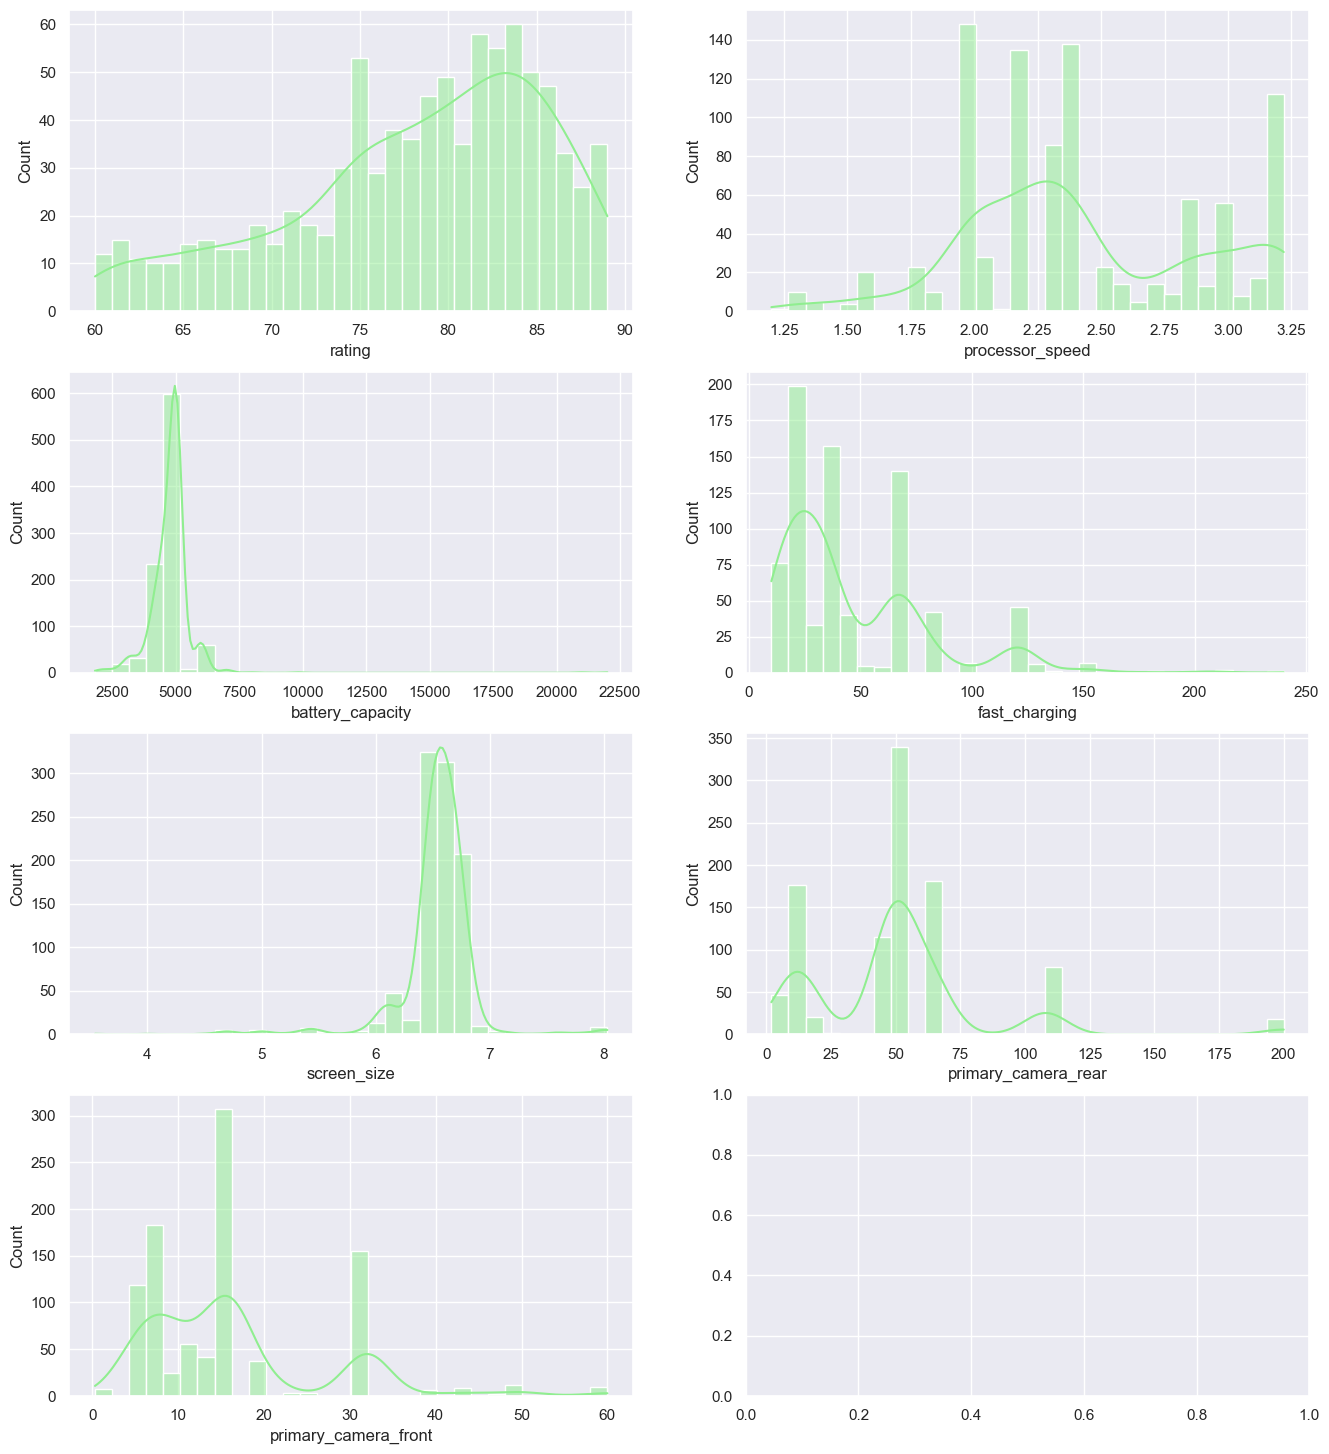

In [196]:
fig, axes = plt.subplots(4, 2, figsize = (16, 18))
axes = axes.flatten()

for i, ax in enumerate(axes):
    if i == 7:
        break
    else:
        sns.histplot(df[numerical_features[i]], bins = 30, color = 'lightgreen', edgecolor = 'white', kde = True, ax = ax)

In [197]:
'''for feature in numerical_features:
    mean = df[feature].mean()
    fig, ax = plt.subplots()
    sns.histplot(df[feature], kde=False, ax=ax, edgecolor="black")
    ax.plot([mean], [-0.6], marker='^', markersize=9, color="red")
    ax.set_title(f'Distribució de {feature}')
    ax.set_xlabel(feature, size=10)
    ax.set_ylabel("Freqüència", size=10)
    plt.tight_layout()
    #plt.savefig(f'./plots/distribution_num/{feature}_distribution.png')'''

'for feature in numerical_features:\n    mean = df[feature].mean()\n    fig, ax = plt.subplots()\n    sns.histplot(df[feature], kde=False, ax=ax, edgecolor="black")\n    ax.plot([mean], [-0.6], marker=\'^\', markersize=9, color="red")\n    ax.set_title(f\'Distribució de {feature}\')\n    ax.set_xlabel(feature, size=10)\n    ax.set_ylabel("Freqüència", size=10)\n    plt.tight_layout()\n    #plt.savefig(f\'./plots/distribution_num/{feature}_distribution.png\')'

#### <span style="color:lightgreen"> Histograma de la freqüència per classe de cada variable categòrica </span>

C:\Users\Usuario\AppData\Local\Temp\ipykernel_7976\3916714006.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data = df, x = categorical_features[i], palette = 'gist_rainbow_r', ax = ax)
C:\Users\Usuario\AppData\Local\Temp\ipykernel_7976\3916714006.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data = df, x = categorical_features[i], palette = 'gist_rainbow_r', ax = ax)
C:\Users\Usuario\AppData\Local\Temp\ipykernel_7976\3916714006.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data = df, x = categorical_features[i], palet

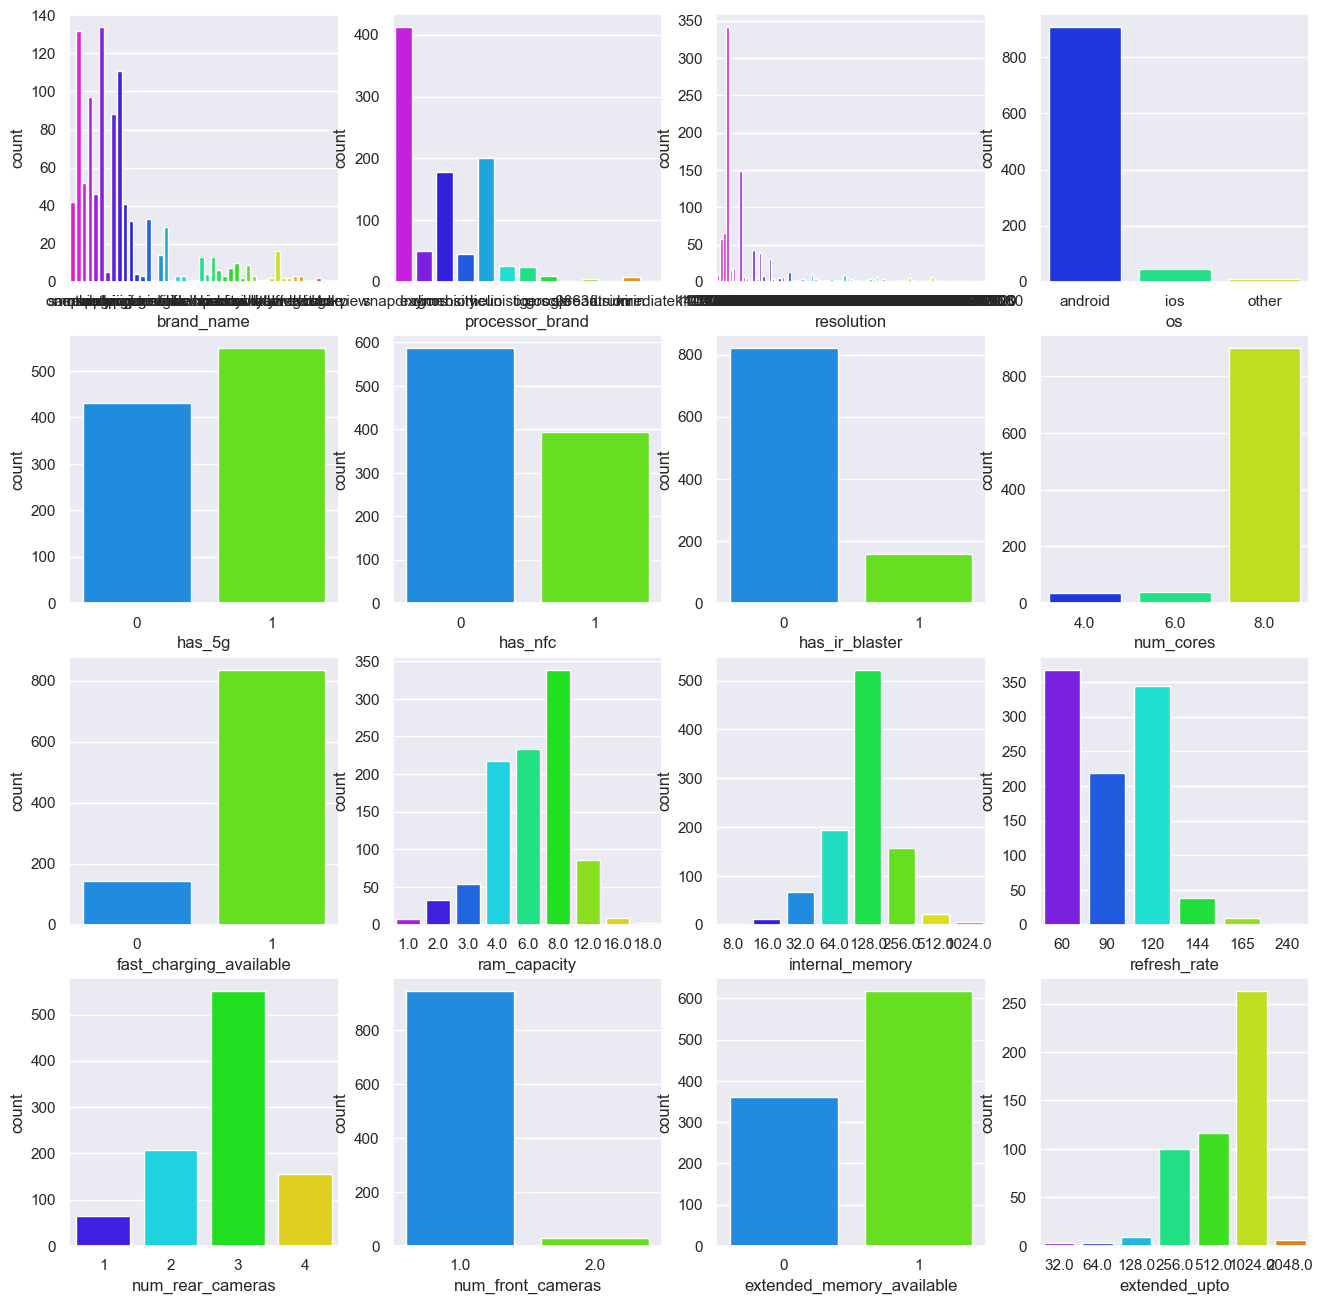

In [198]:
fig, axes = plt.subplots(4, 4, figsize = (16, 16))
axes = axes.flatten()

for i, ax in enumerate(axes):
    sns.countplot(data = df, x = categorical_features[i], palette = 'gist_rainbow_r', ax = ax)

In [199]:
'''for feature in categorical_features:
    plt.figure()
    df[feature].value_counts().plot(kind='bar', color='green')
    plt.title(f'Freqüència per classe del feature {feature}')
    if feature == 'resolution':
        plt.xticks(rotation=90, fontsize=8)  
    else:
        plt.xticks(rotation=70, fontsize=10)
    plt.tight_layout()
    #plt.savefig(f'./plots/frequency_cat/{feature}_frequency.png')'''

"for feature in categorical_features:\n    plt.figure()\n    df[feature].value_counts().plot(kind='bar', color='green')\n    plt.title(f'Freqüència per classe del feature {feature}')\n    if feature == 'resolution':\n        plt.xticks(rotation=90, fontsize=8)  \n    else:\n        plt.xticks(rotation=70, fontsize=10)\n    plt.tight_layout()\n    #plt.savefig(f'./plots/frequency_cat/{feature}_frequency.png')"

#### <span style="color:lightgreen"> Correlacions entre variables numèriques </span>

In [200]:
'''corr_matrix = df[numerical_features].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', cbar=True)
#plt.savefig('./plots/correlations_heatmap.png')
plt.show()'''

'corr_matrix = df[numerical_features].corr()\n\nplt.figure(figsize=(10, 8))\nsns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap=\'coolwarm\', cbar=True)\n#plt.savefig(\'./plots/correlations_heatmap.png\')\nplt.show()'

#### <span style="color:lightgreen"> Correlació entre variables categòriques i variable objectiu </span>

In [201]:
'''for feature in categorical_features:
    plt.figure(figsize=(10, 5))
    sns.boxplot(x=feature, y='price', data=df)
    plt.title(f'Distribución de price según {feature}')
    plt.xticks(rotation=45)
    plt.show()'''

"for feature in categorical_features:\n    plt.figure(figsize=(10, 5))\n    sns.boxplot(x=feature, y='price', data=df)\n    plt.title(f'Distribución de price según {feature}')\n    plt.xticks(rotation=45)\n    plt.show()"

#### <span style="color:lightgreen"> Correlació entre variables numèriques i variable objectiu </span>

In [202]:
'''sns.set(style="whitegrid")

for feature in numerical_features:
    plt.figure(figsize=(8, 6))  # Ajusta el tamaño de la figura
    sns.regplot(x=feature, y='price', data=df, scatter_kws={'alpha':0.5}, line_kws={"color": "red"})  # alpha para transparencia de puntos
    plt.title(f'Relación entre Price y {feature} con línea de regresión')  # Título del gráfico
    plt.xlabel(feature)  # Etiqueta del eje x
    plt.ylabel('Price')  # Etiqueta del eje y
    plt.show()'''

'sns.set(style="whitegrid")\n\nfor feature in numerical_features:\n    plt.figure(figsize=(8, 6))  # Ajusta el tamaño de la figura\n    sns.regplot(x=feature, y=\'price\', data=df, scatter_kws={\'alpha\':0.5}, line_kws={"color": "red"})  # alpha para transparencia de puntos\n    plt.title(f\'Relación entre Price y {feature} con línea de regresión\')  # Título del gráfico\n    plt.xlabel(feature)  # Etiqueta del eje x\n    plt.ylabel(\'Price\')  # Etiqueta del eje y\n    plt.show()'

# 2. Preprocessament

#### <span style="color:lightgreen"> Missings </span>

In [203]:
'''import missingno as msno

msno.matrix(df)'''

'import missingno as msno\n\nmsno.matrix(df)'

In [204]:
def missing_data(data):
    total_missing = data.isna().sum().sort_values(ascending=False)
    percent_missing = round(100 * (data.isnull().sum() / len(data)), 2).sort_values(ascending=False)
    missing_data = pd.DataFrame({'Total Missing': total_missing, 'Percent Missing (%)': percent_missing})
    return missing_data
missing_data(df)

,Total Missing,Percent Missing (%)
extended_upto,480,48.98
fast_charging,211,21.53
rating,101,10.31
processor_speed,42,4.29
processor_brand,20,2.04
os,14,1.43
battery_capacity,11,1.12
num_cores,6,0.61
primary_camera_front,5,0.51
num_front_cameras,4,0.41


Eliminem 'extended_upto' ja que té gairebé un 50% de missings

In [205]:
categorical_features.remove('extended_upto')
df = df.drop('extended_upto', axis=1)

Els altres missings els imputarem un cop particionem el dataset en train i test

#### <span style="color:lightgreen"> Outliers </span>

In [206]:
'''for feature in numerical_features:
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))

    # Plot boxplot
    sns.boxplot(x=df[feature], ax=axes[0])
    axes[0].set_title(f'{feature} with outliers')

    # Plot distribution
    sns.histplot(data=df, x=feature, kde=True, ax=axes[1])
    axes[1].set_title(f'{feature} Distribution')

    plt.tight_layout()
    #fig.savefig(f'./plots/dist_with_outliers/{feature}_with_outliers.png')'''

"for feature in numerical_features:\n    fig, axes = plt.subplots(1, 2, figsize=(12, 6))\n\n    # Plot boxplot\n    sns.boxplot(x=df[feature], ax=axes[0])\n    axes[0].set_title(f'{feature} with outliers')\n\n    # Plot distribution\n    sns.histplot(data=df, x=feature, kde=True, ax=axes[1])\n    axes[1].set_title(f'{feature} Distribution')\n\n    plt.tight_layout()\n    #fig.savefig(f'./plots/dist_with_outliers/{feature}_with_outliers.png')"

Eliminarem els outliers seguint el criteri del Rang Interquartil, excepte la variable objectiu 'price'

Per tant, considerarem outliers:
* Els valors més grans que Q1 - 1.5*IQR
* Els valors més petits que Q3 + 1.5*IQR


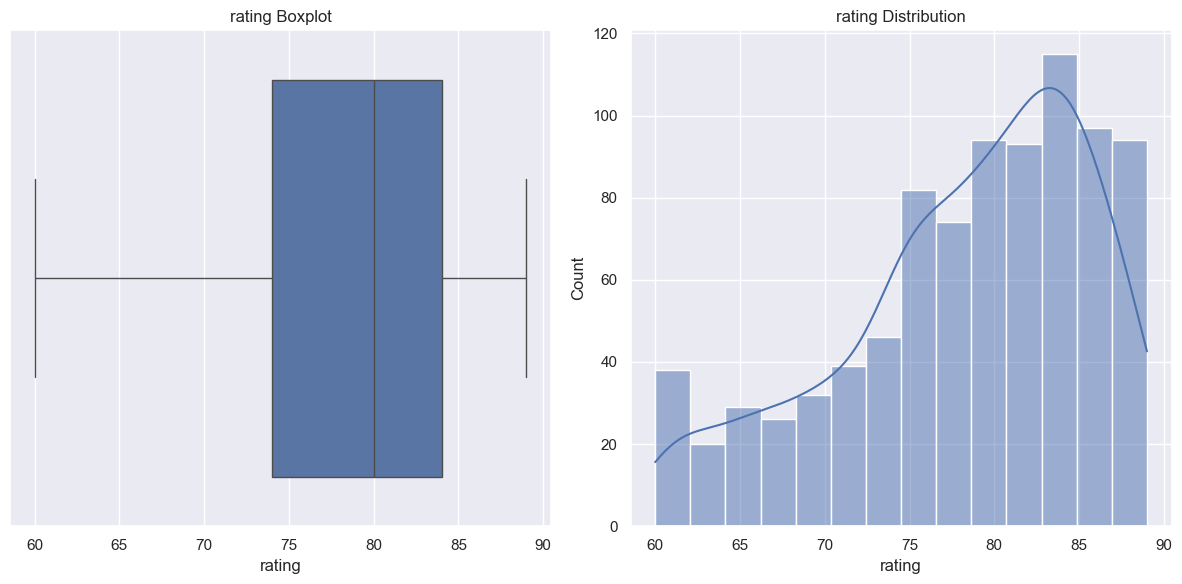

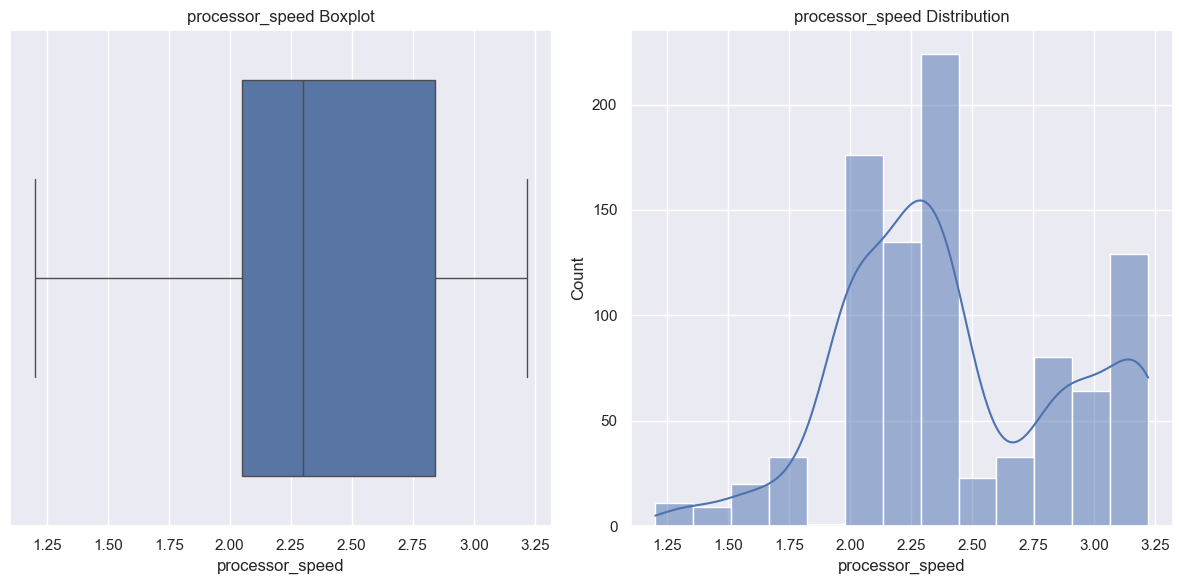

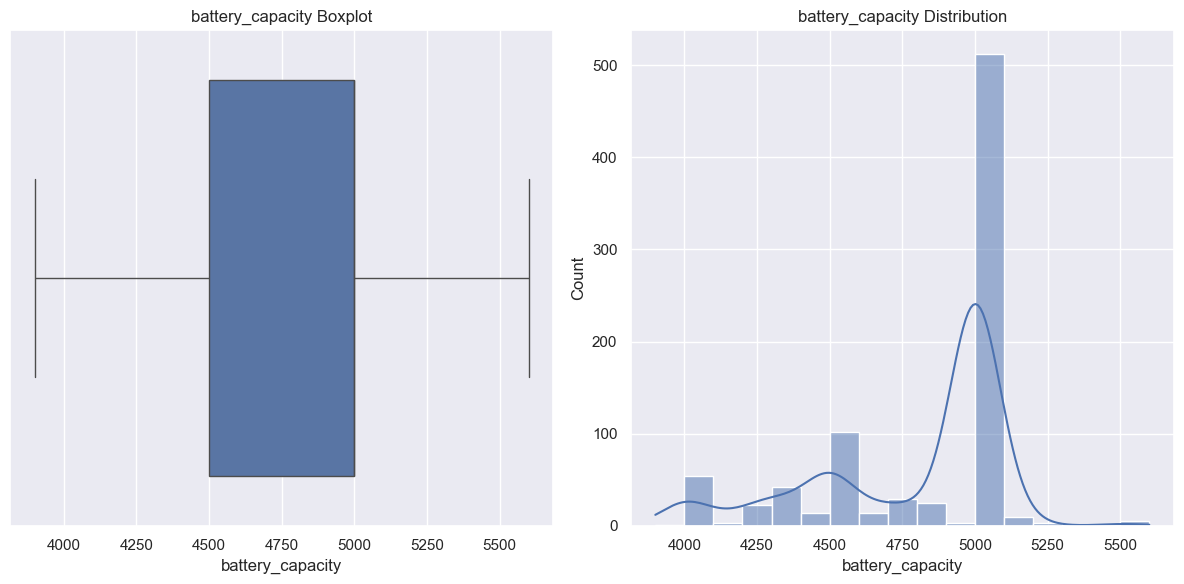

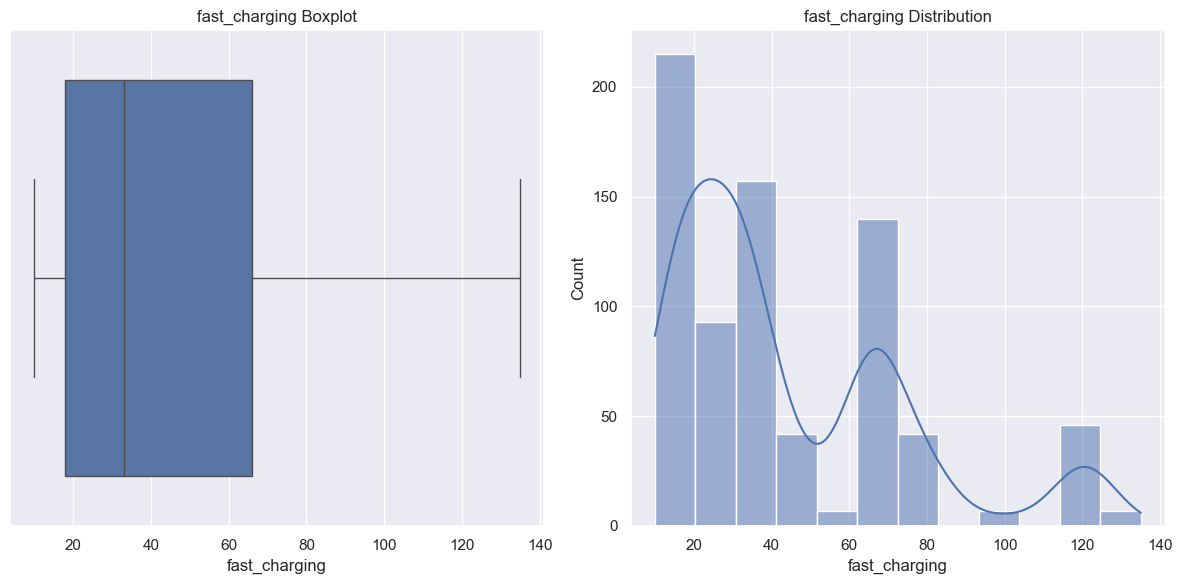

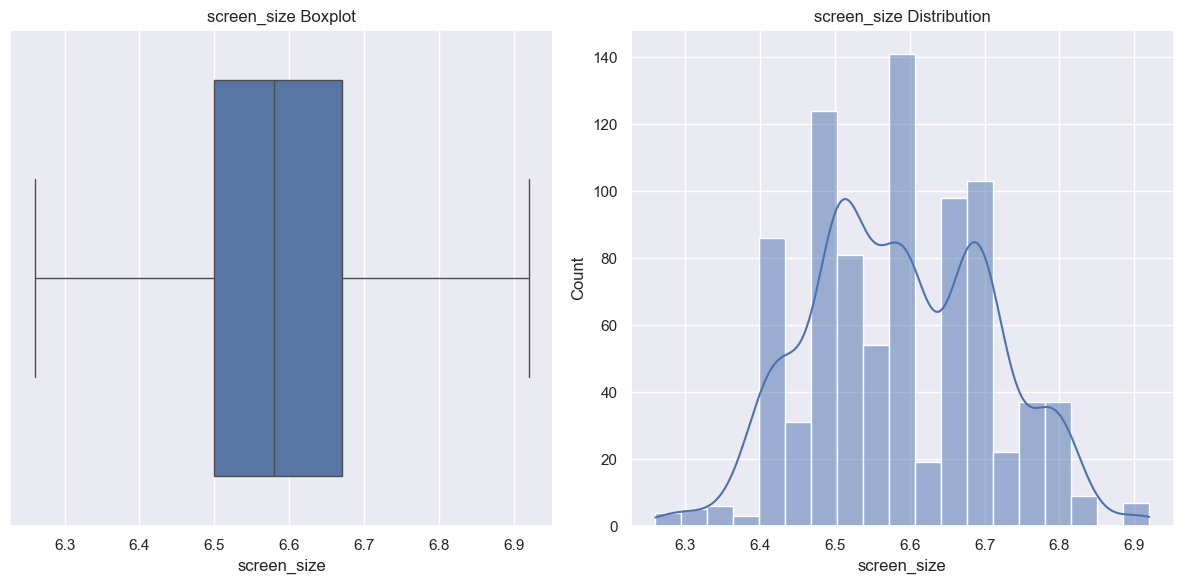

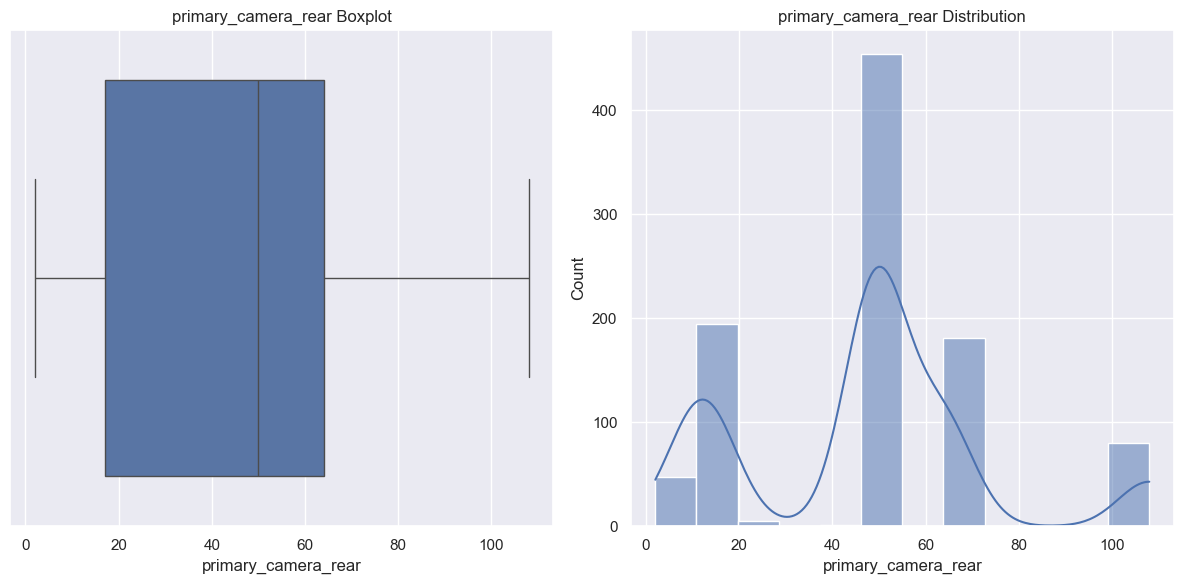

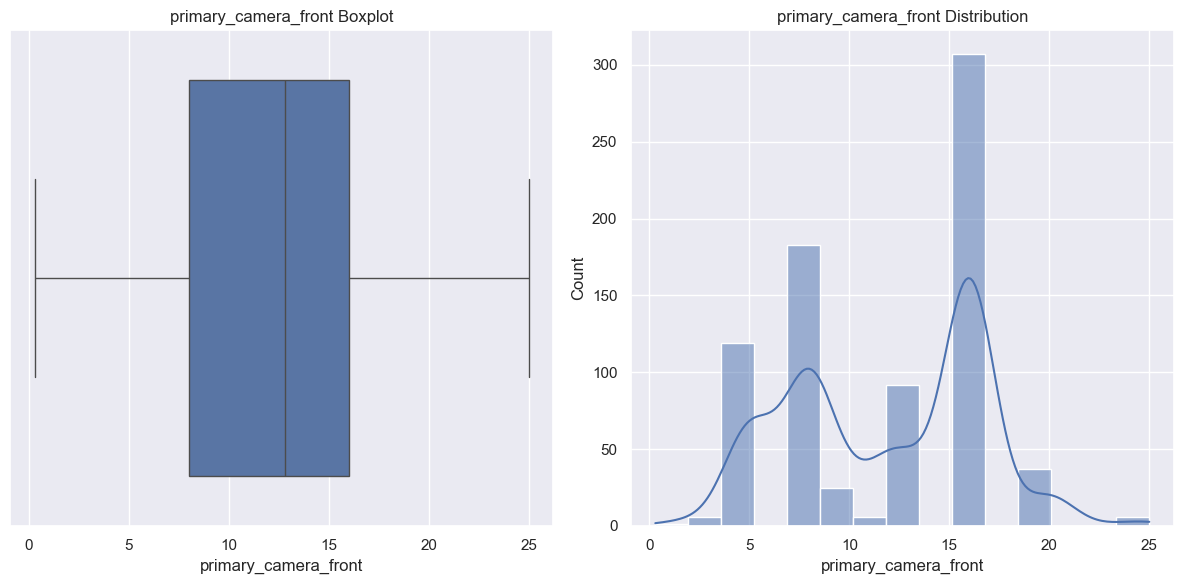

In [207]:
for feature in numerical_features:
    # Calcular IQR
    Q1 = df[feature].quantile(0.25)
    Q3 = df[feature].quantile(0.75)
    IQR = Q3 - Q1

    # Definir el límit inferior i superior
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Replace outliers with NaN
    df.loc[(df[feature] < lower_bound) | (df[feature] > upper_bound), feature] = np.nan

    fig, axes = plt.subplots(1, 2, figsize=(12, 6))

    # Plot boxplot
    sns.boxplot(x=df[feature], ax=axes[0])
    axes[0].set_title(f'{feature} Boxplot')

    # Plot distribution
    sns.histplot(data=df, x=feature, kde=True, ax=axes[1])
    axes[1].set_title(f'{feature} Distribution')

    plt.tight_layout()
    #fig.savefig(f'./plots/dist_without_outliers/{feature}_without_outliers.png')

#### <span style="color:lightgreen"> Recodificació de variables categòriques </span>

AIXO POTSER S'HA DE TREURE, JA QUE HO FEM QUAN PARTIM EL DATASET

In [208]:
from sklearn.preprocessing import LabelEncoder

def label_encode(df, categorical_columns):
    encoded_df = df.copy()

    for col in categorical_columns:
        le = LabelEncoder()
        encoded_df[col] = le.fit_transform(encoded_df[col].astype(str))

    return encoded_df

In [209]:
df_encoded = label_encode(df, categorical_features)

df_encoded[categorical_features].describe()

,brand_name,processor_brand,resolution,os,has_5g,has_nfc,has_ir_blaster,num_cores,fast_charging_available,ram_capacity,internal_memory,refresh_rate,num_rear_cameras,num_front_cameras,extended_memory_available
count,980.000000,980.000000,980.000000,980.000000,980.000000,980.000000,980.000000,980.000000,980.000000,980.000000,980.000000,980.000000,980.000000,980.000000,980.000000
mean,30.481633,6.477551,28.763265,0.109184,0.560204,0.401020,0.162245,1.892857,0.854082,6.285714,2.613265,2.680612,1.814286,0.037755,0.630612
std,12.368643,4.018917,27.656234,0.439748,0.496616,0.490355,0.368864,0.426102,0.353205,2.085016,1.998576,2.121208,0.776441,0.211041,0.482885
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,25.000000,2.000000,8.000000,0.000000,0.000000,0.000000,0.000000,2.000000,1.000000,6.000000,1.000000,0.000000,1.000000,0.000000,0.000000
50%,33.000000,6.500000,11.000000,0.000000,1.000000,0.000000,0.000000,2.000000,1.000000,7.000000,1.000000,4.000000,2.000000,0.000000,1.000000
75%,43.000000,10.000000,55.250000,0.000000,1.000000,1.000000,0.000000,2.000000,1.000000,8.000000,4.000000,4.000000,2.000000,0.000000,1.000000
max,45.000000,13.000000,82.000000,3.000000,1.000000,1.000000,1.000000,3.000000,1.000000,8.000000,7.000000,5.000000,3.000000,2.000000,1.000000


#### <span style="color:lightgreen"> Normalització de variables numèriques </span>

AIXO POTSER S'HA DE TREURE, JA QUE HO FEM QUAN PARTIM EL DATASET

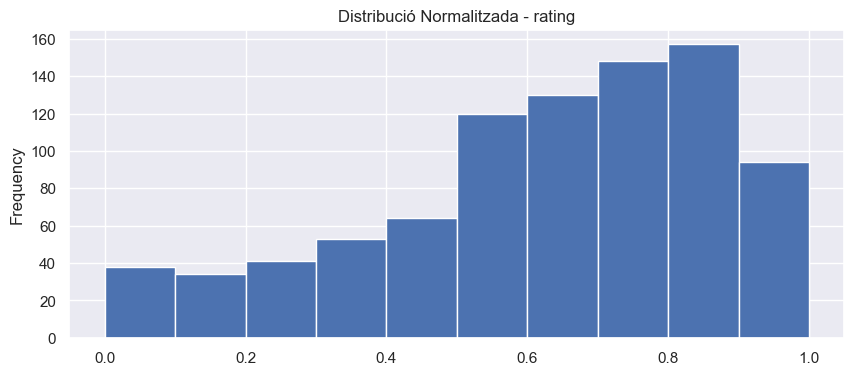

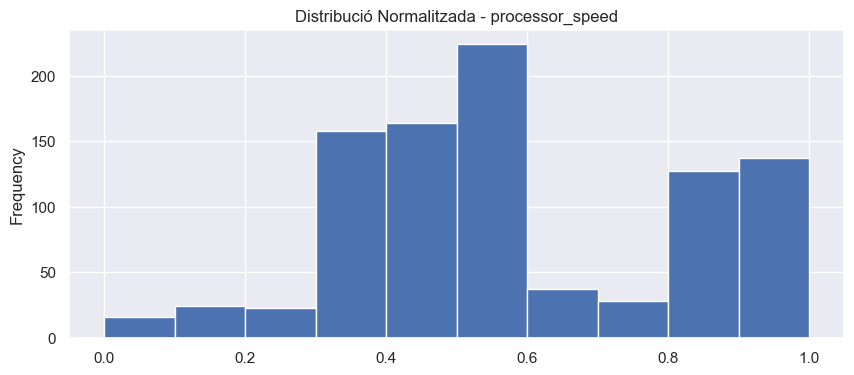

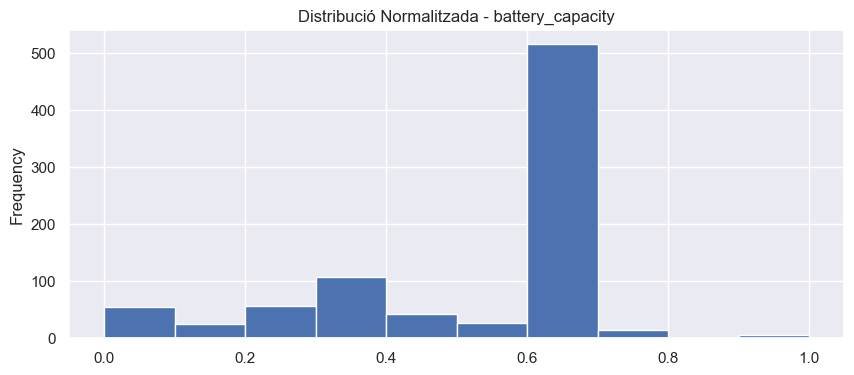

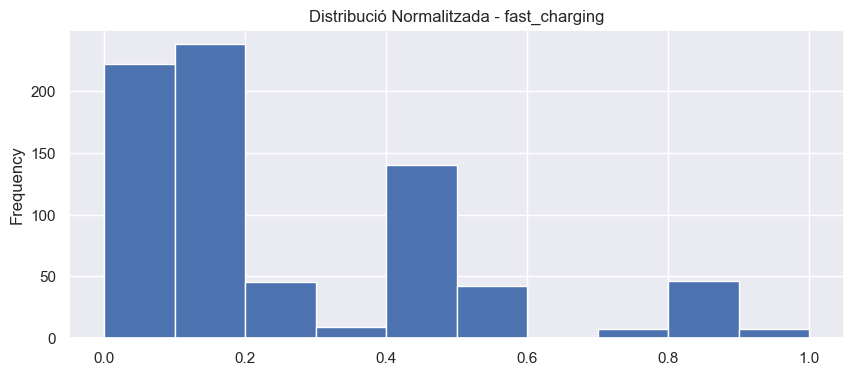

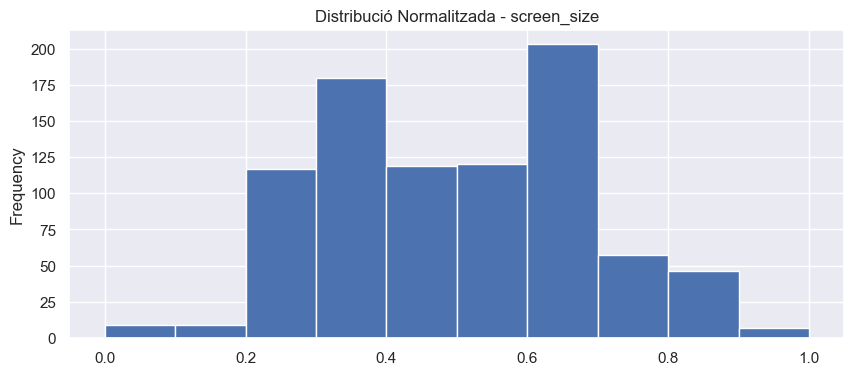

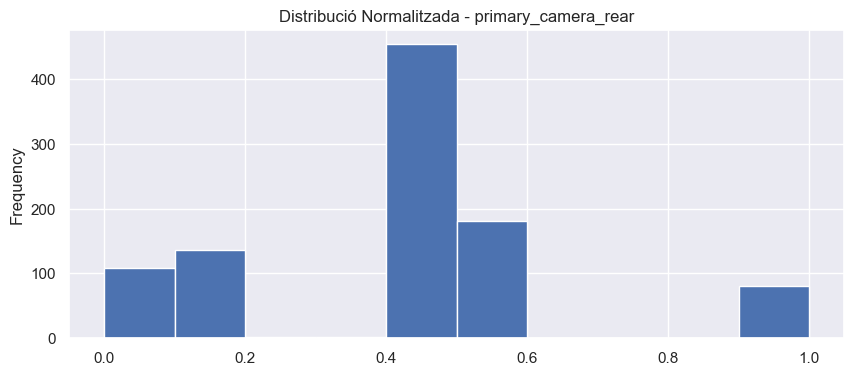

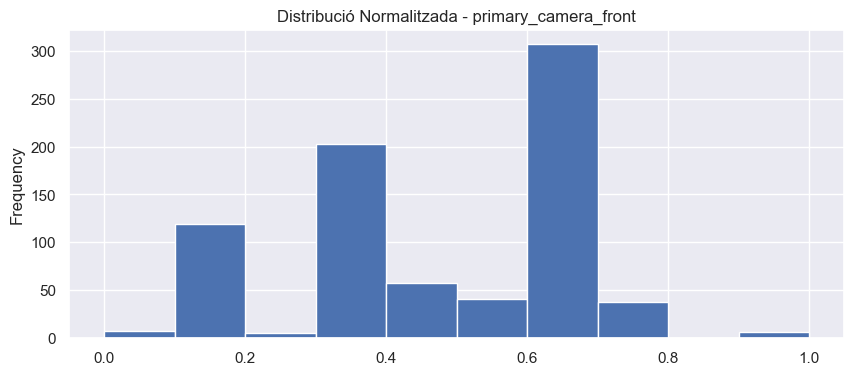

In [210]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
df_normalized = pd.DataFrame(scaler.fit_transform(df[numerical_features]), columns=numerical_features)

for feature in numerical_features:
    plt.figure(figsize=(10, 4))
    df_normalized[feature].plot.hist()
    plt.title(f'Distribució Normalitzada - {feature}')
    #plt.savefig(f'./plots/normalized/{feature}_normalized.png')

In [211]:
df_normalized[numerical_features].sample(10, random_state=25) 

,rating,processor_speed,battery_capacity,fast_charging,screen_size,primary_camera_rear,primary_camera_front
211,0.655172,0.594059,0.647059,0.064,0.363636,0.433962,0.635628
119,0.965517,0.990099,0.000000,0.120,NaN,0.452830,0.473684
233,0.551724,0.495050,0.647059,0.184,0.454545,0.452830,0.311741
634,0.827586,0.891089,0.352941,0.320,0.257576,0.584906,0.635628
404,0.931034,0.891089,0.352941,0.440,0.439394,0.584906,NaN
49,NaN,0.574257,0.647059,0.184,0.666667,1.000000,NaN
349,0.206897,0.396040,0.647059,0.000,0.409091,0.103774,0.190283
35,0.931034,0.841584,0.352941,0.120,0.212121,0.094340,NaN
153,0.931034,0.891089,0.647059,0.456,0.666667,1.000000,0.635628
186,0.896552,0.495050,0.647059,0.160,0.515152,0.452830,0.635628


# 3. Remostreig

#### <span style="color:lightgreen"> Partició del dataset en Train i Test </span>

In [212]:
from sklearn.model_selection import train_test_split

X = df.drop('price', axis=1) 
y = df['price']

# Dividir el dataset en train y test 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=33)

In [213]:
# Mostrar el número d'observacions y features de cada set
sets_df = pd.DataFrame(columns=['Set', 'Number of Observations', 'Number of Features'])
sets_df.loc[len(sets_df)] = ['Train', X_train.shape[0], X_train.shape[1]]
sets_df.loc[len(sets_df)] = ['Test', X_test.shape[0], X_test.shape[1]]

sets_df

,Set,Number of Observations,Number of Features
0,Train,784,22
1,Test,196,22


#### <span style="color:lightgreen"> Imputació de Missings</span>

##### Variables numèriques

In [214]:
missing_before_num = X_train[numerical_features].isnull().sum()
mean_before = X_train[numerical_features].mean()
stderr_before = X_train[numerical_features].sem()
median_before = X_train[numerical_features].median()

In [215]:
from sklearn.impute import KNNImputer

# Crear l'imputador KNN
imputer = KNNImputer(n_neighbors=5)

# Ajustar l'imputador a les característiques numèriques de les dades d'entrenament i transformar-les
X_train[numerical_features] = imputer.fit_transform(X_train[numerical_features])

# Transformar les característiques numèriques de les dades de prova utilitzant l'imputador ajustat
X_test[numerical_features] = imputer.transform(X_test[numerical_features])

In [216]:
missing_after_num = X_train[numerical_features].isnull().sum()
mean_after = X_train[numerical_features].mean()
stderr_after = X_train[numerical_features].sem()
median_after = X_train[numerical_features].median()

In [217]:
stats_comparison_num = pd.DataFrame({
    'Feature': missing_before_num.index, 
    'Mean (old)': mean_before.values,
    'Mean': mean_after.values,
    'Std_Error (old)': stderr_before.values,
    'Std_Error': stderr_after.values,
    'Median (old)': median_before.values,
    'Median': median_after.values
})
stats_comparison_num

,Feature,Mean (old),Mean,Std_Error (old),Std_Error,Median (old),Median
0,rating,78.435277,78.141327,0.278898,0.271453,80.00,80.00
1,processor_speed,2.438262,2.442957,0.017143,0.016642,2.36,2.40
2,battery_capacity,4783.869048,4772.254847,12.888929,11.359259,5000.00,5000.00
3,fast_charging,43.960265,44.491327,1.215199,1.099123,33.00,33.00
4,screen_size,6.589594,6.591130,0.004493,0.004077,6.58,6.59
5,primary_camera_rear,47.346814,47.209566,0.937638,0.927218,50.00,50.00
6,primary_camera_front,11.964912,12.524031,0.188571,0.159620,12.60,13.80


##### Variables categòriques

In [218]:
# Guardar les dades originals
original_data = X_train.copy()

In [219]:
# Llista amb els noms de les variables categòriques que tenen almenys un missing
cat_features_missings = [feature for feature in categorical_features if X_train[feature].isnull().any()]
print(cat_features_missings)

['processor_brand', 'os', 'num_cores', 'num_front_cameras']


In [220]:
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy='most_frequent')

X_train[categorical_features] = imputer.fit_transform(X_train[categorical_features])
X_test[categorical_features] = imputer.transform(X_test[categorical_features])

In [221]:
'''for feature in cat_features_missings:
    plt.figure(figsize=(10, 4))

    # Abans de la imputació (excloïm missings)
    plt.subplot(1, 2, 1)
    filtered_data = original_data[original_data[feature].notna()]
    sns.countplot(data=filtered_data, x=feature, color='green')
    plt.title(f'{feature} - Original')
    plt.xticks(rotation=60)  

    # Després de la imputació
    plt.subplot(1, 2, 2)
    sns.countplot(data=X_train, x=feature, color='green')
    plt.title(f'{feature} - Després de la Imputació')
    plt.xticks(rotation=60)  

    #plt.savefig(f'./plots/dist_moda/{feature}_moda.png')'''

"for feature in cat_features_missings:\n    plt.figure(figsize=(10, 4))\n\n    # Abans de la imputació (excloïm missings)\n    plt.subplot(1, 2, 1)\n    filtered_data = original_data[original_data[feature].notna()]\n    sns.countplot(data=filtered_data, x=feature, color='green')\n    plt.title(f'{feature} - Original')\n    plt.xticks(rotation=60)  \n\n    # Després de la imputació\n    plt.subplot(1, 2, 2)\n    sns.countplot(data=X_train, x=feature, color='green')\n    plt.title(f'{feature} - Després de la Imputació')\n    plt.xticks(rotation=60)  \n\n    #plt.savefig(f'./plots/dist_moda/{feature}_moda.png')"

#### <span style="color:lightgreen"> Recodificació de variables categòriques </span>

In [222]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder

# Crear una còpia dels conjunts de dades per no modificar els originals
X_train_encoded = X_train.copy()
X_test_encoded = X_test.copy()

# Crear el codificador
le = LabelEncoder()

# Obtindre totes les categories úniques per a 'brand_name' i 'processor_brand'
all_brands = pd.concat([X_train['brand_name'], X_test['brand_name']]).dropna().unique()
all_processors = pd.concat([X_train['processor_brand'], X_test['processor_brand']]).dropna().unique()

# One-Hot Encoding per 'brand_name' i 'processor_brand'
for col, all_categories in zip(['brand_name', 'processor_brand'], [all_brands, all_processors]):
    dummies = pd.get_dummies(pd.concat([X_train[col], X_test[col]], axis=0), prefix=col, drop_first=True)
    X_train_encoded = pd.concat([X_train_encoded, dummies.loc[X_train.index]], axis=1)
    X_test_encoded = pd.concat([X_test_encoded, dummies.loc[X_test.index]], axis=1)
    X_train_encoded.drop([col], axis=1, inplace=True)
    X_test_encoded.drop([col], axis=1, inplace=True)

# Codificar les altres columnes categòriques de tipus object
for col in categorical_features:
    if col not in ['brand_name', 'processor_brand'] and X_train_encoded[col].dtype == 'object':
        le.fit(pd.concat([X_train_encoded[col], X_test_encoded[col]])) 
        X_train_encoded[col] = le.transform(X_train_encoded[col])
        X_test_encoded[col] = le.transform(X_test_encoded[col])

In [223]:
X_train_encoded.shape

(784, 77)

#### <span style="color:lightgreen"> Normalització de variables numèriques </span>

In [224]:
from sklearn.preprocessing import StandardScaler

# Crear una còpia dels conjunts de dades per no modificar els originals
X_train_normalized = X_train_encoded.copy()
X_test_normalized = X_test_encoded.copy()

# Crear el normalitzador
scaler = StandardScaler()

# Normalitzar les columnes numèriques
X_train_normalized[numerical_features] = scaler.fit_transform(X_train_normalized[numerical_features])
X_test_normalized[numerical_features] = scaler.transform(X_test_normalized[numerical_features])

In [225]:
'''for feature in numerical_features:
    plt.figure(figsize=(10, 4))
    X_train_normalized[feature].plot.hist()
    plt.title(f'Distribució Normalitzada - {feature}')
    #plt.savefig(f'./plots/normalized/{feature}_normalized.png')'''

"for feature in numerical_features:\n    plt.figure(figsize=(10, 4))\n    X_train_normalized[feature].plot.hist()\n    plt.title(f'Distribució Normalitzada - {feature}')\n    #plt.savefig(f'./plots/normalized/{feature}_normalized.png')"

#### <span style="color:lightgreen"> CV per avaluar el model </span>

# 4. Model Lineal Base

#### <span style="color:lightgreen"> Entrenament i avaluació d'un model de regressió lineal </span>

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

# Crea el model de regressió lineal
model = LinearRegression()

# Entrena el model
model.fit(X_train_normalized, y_train)

# Fes prediccions amb les dades de prova
y_pred = model.predict(X_test_normalized)

# Avaluar el model
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"MSE: {mse}")
print(f"MAE: {mae}")
print(f"R²: {r2}")

#### <span style="color:lightgreen"> Interpretació dels resultats obtinguts (mètriques de classificació, coeficients, etc.) </span>

------------------------------------------------------------------------------------------------------------------------------------------------------------

# EXTRA: Trobar el millor model per aquest problema de regressió

In [ ]:
from sklearn.model_selection import cross_val_score, KFold
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

# Crear un diccionari de models a avaluar
models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(max_iter=10000),
    'Lasso Regression': Lasso(max_iter=10000),
    'Random Forest': RandomForestRegressor(),
    'K-Nearest Neighbors': make_pipeline(StandardScaler(), KNeighborsRegressor()) 
}

# Configuració de la validació creuada
kf = KFold(n_splits=10, shuffle=True, random_state=42)

# Avaluar cada model fent servir el R2 Score
results = {}
for name, model in models.items():
    cv_results = cross_val_score(model, X_train_normalized, y_train, cv=kf, scoring='r2')
    results[name] = cv_results.mean()  

# Trobar el model que dona un millor resultat de R2
best_model = max(results, key=results.get)
print("Millor model:", best_model)
print("R2-score de cada model:", results)


In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor

# Definir el model
model = RandomForestRegressor()

# Definir els hiperparàmetres a provar
param_grid = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

# Crear el Grid Search
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=10, scoring='r2', verbose=2, n_jobs=-1)

# Ajustar el Grid Search als dades
grid_search.fit(X_train_normalized, y_train)

# Imprimir els millors hiperparàmetres trobats
print(f'Millors hiperparàmetres: {grid_search.best_params_}')
print(f'Millor score: {grid_search.best_score_}')

Millors hiperparàmetres: {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}